In [1]:
from studies.study_factory import StudyFactory
from utils.pre_processor import PreProcessor
import pandas as pd
import numpy as np
import torch
import copy
import os

In [2]:
study = StudyFactory().create_study("schoffelen", path="data/schoffelen")
brain_sample_rate = 100

pre_processor = PreProcessor(
    brain_sample_rate=brain_sample_rate,
)

# frequency_bands = {
#     'delta': (0.5, 4),
#     'theta': (4, 8),
#     'alpha': (8, 12),
#     'beta': (12, 30),
#     'gamma': (30, 100),
# }
frequency_bands = {"all": (0.5, 100)}
subject, task, session = 0, 0, 0
seed = 42
max_random_shift = 1
window_size = 4
n_jobs = -1

raw, word_events, sound_events = study.clean_recording(
    subject, task, session, n_jobs=n_jobs
)

In [3]:
# Obtain the list of start and end times for the windows
# Making sure windows don't span two different sound files
# dict of list of tuples, list of tuples
audio_window_timestamps, brain_window_timestamps = {}, []

for sound_file in sorted(sound_events["sound"].unique()):

    start_time, end_time = (
        sound_events[sound_events["sound"] == sound_file]["onset"].iloc[0],
        sound_events[sound_events["sound"] == sound_file]["end"].iloc[0],
    )

    audio_start_time = copy.deepcopy(start_time)
    audio_window_timestamps[sound_file] = []

    # This works on onset times (brain)
    while start_time + window_size < end_time:

        brain_window_timestamps.append((start_time, start_time + window_size))

        # Notes the corresponsing timestamps in the audio file
        audio_window_timestamps[sound_file].append(
            (start_time - audio_start_time, start_time + window_size - audio_start_time)
        )
        start_time += np.random.uniform(1, 1 + max_random_shift)  # some randomness

In [4]:
results = pre_processor.pre_process_brain(
    raw,
    channel_names=study.channel_names,
    n_jobs=n_jobs,
    frequency_bands=frequency_bands,
    brain_clipping=20,
)

# np array of time stamps corresponsing to brain data
times = torch.from_numpy(results[list(frequency_bands.keys())[0]].times)

n_windows = len(brain_window_timestamps)
data, brain_segments = {}, {}

# Initialize output arrays for each band, of shape [B, C, T] (with padding)
for band in frequency_bands.keys():

    data[band] = torch.from_numpy(results[band].get_data())  # [C, T]
    n_channels = data[band].shape[0]
    brain_segments[band] = torch.zeros(
        (n_windows, n_channels, window_size * brain_sample_rate), dtype=data[band].dtype
    )

# Extract windows for all bands
for i, (start_time, end_time) in enumerate(brain_window_timestamps):

    mask = (times >= start_time) & (times <= end_time)

    for band in frequency_bands.keys():
        window = data[band][:, mask]  # Extract window
        brain_segments[band][i] = window[
            :, : window_size * brain_sample_rate
        ]  # Truncate to [C, T]

In [8]:
hop_length = 160
audio_sample_rate = 16000
audio_segments = []

for sound_file in sorted(sound_events["sound"].unique()):

    audio_segment = pre_processor.pre_process_audio(
        path=os.path.join(study.root_dir, sound_file),
        window_size=window_size,
        hop_length=hop_length,
        time_stamps=audio_window_timestamps[sound_file],
    )  # [B, mel_bins, T]
    audio_segment = audio_segment[
        :, :, : int(window_size * audio_sample_rate / hop_length)
    ]  # Truncate temporal dim
    audio_segments.append(audio_segment)

audio_segments = torch.cat(audio_segments, dim=0)

if (
    brain_segments[list(frequency_bands.keys())[0]].shape[0] != audio_segments.shape[0]
) or (
    brain_segments[list(frequency_bands.keys())[0]].shape[-1]
    != audio_segments.shape[-1]
):
    raise ValueError("Number of brain and audio windows do not match")

In [9]:
torch.save(
    {
        "brain": brain_segments,
        "audio": audio_segments,
    },
    f"{study.cache_dir}/{subject}_{task}_{session}.pt",
)

In [10]:
load = torch.load(f"{study.cache_dir}/{subject}_{task}_{session}.pt")
b, a = load["brain"], load["audio"]
print(b[list(frequency_bands.keys())[0]].shape, a.shape)

torch.Size([2182, 269, 400]) torch.Size([2182, 128, 400])


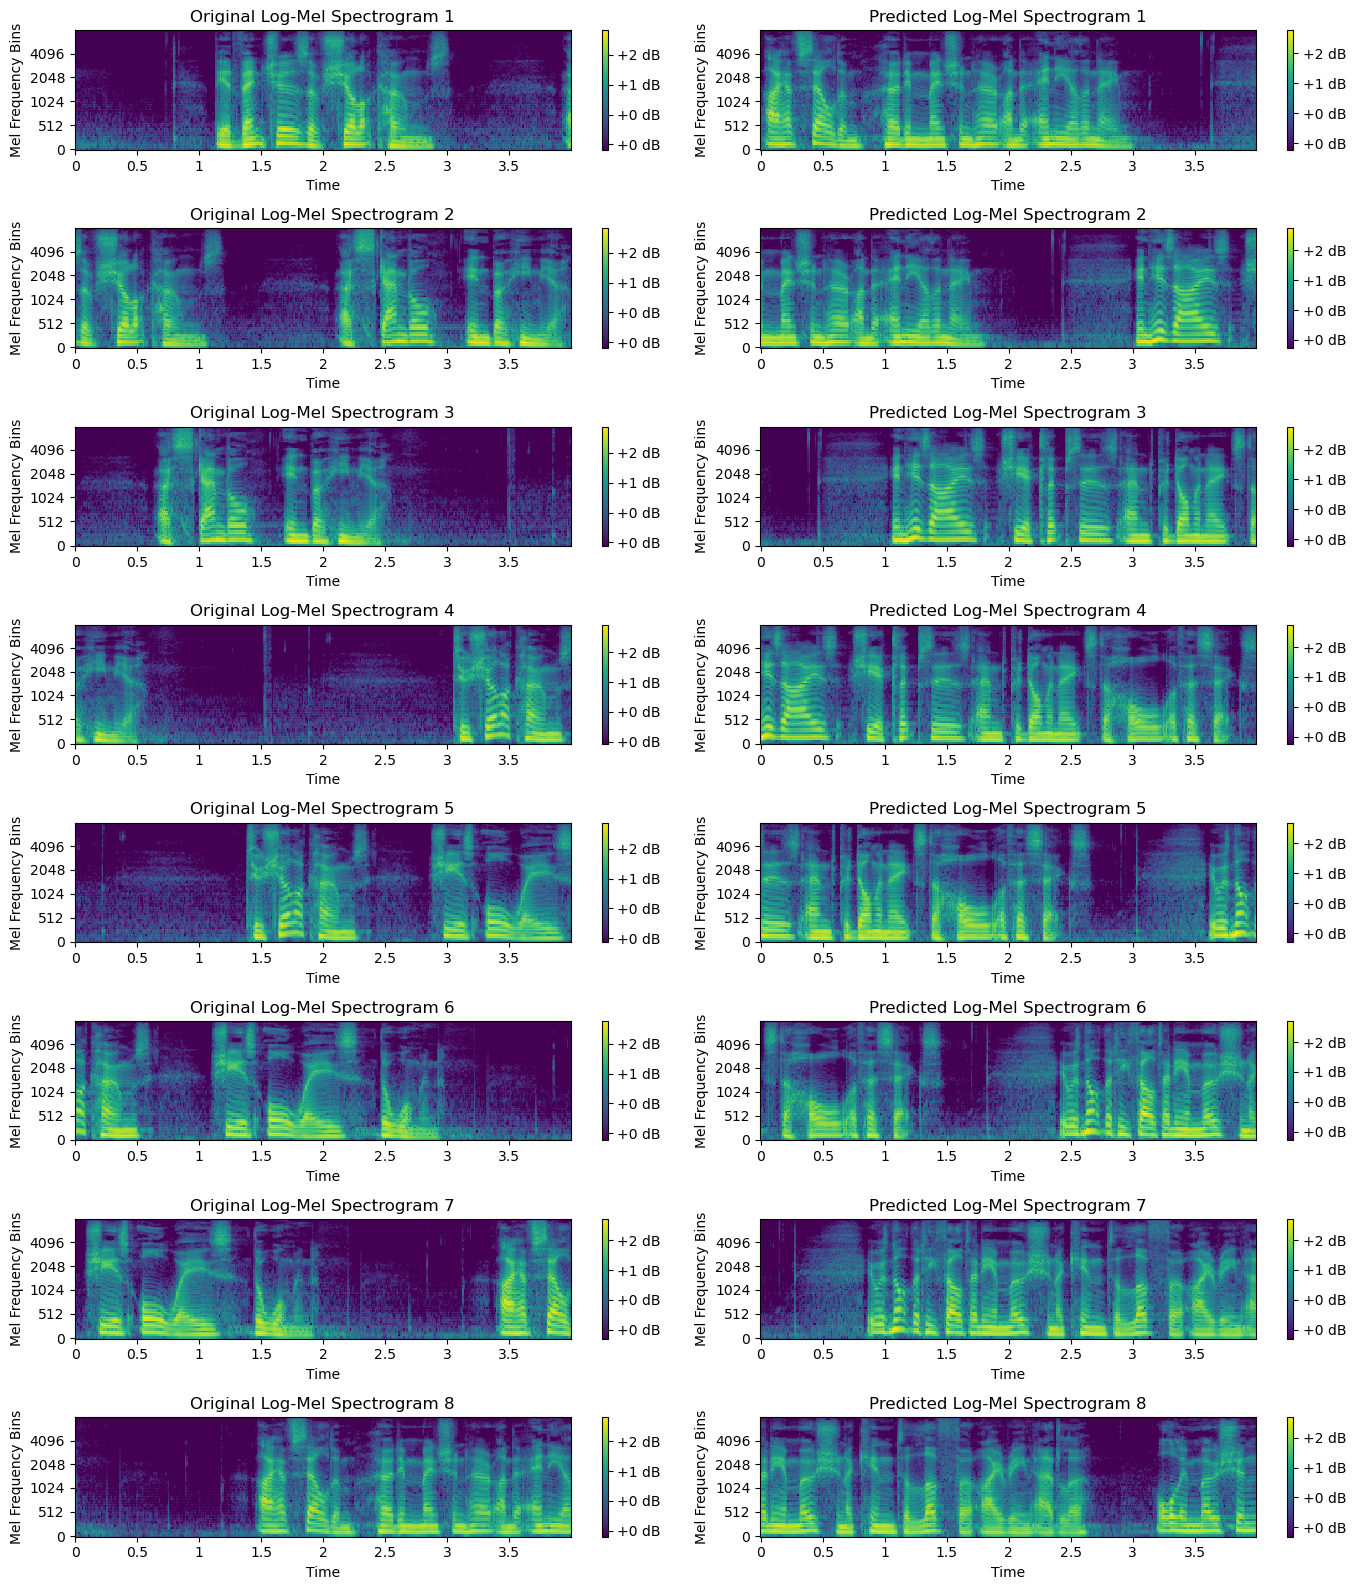

In [12]:
from utils.plot import mel_spectrogram

mel_spectrogram(
    x=a,
    max_plots = 8,
    x_pred = a[8:],
    audio_hop_length=hop_length,
    audio_sample_rate=audio_sample_rate,
)